In [165]:
import pandas as pd
import numpy as np
import math
from scipy.stats import multivariate_normal
from scipy import random
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
import PIL
from sklearn.model_selection import train_test_split
from skimage.feature import peak_local_max

In [166]:
df = pd.read_csv('data/poi.csv', header=None, index_col=False)
df.columns = ['index', 'x', 'y']
df = df.drop(['index'], axis=1)
colnames = list(df.columns[0:2])

In [167]:
def initiate_centroids(dset=df, k=3):
    '''Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    #np.random.seed(42)
    
    # pandas.sample samples randomly and uniformly. 
    centroids = dset.sample(k, replace=False)
    return centroids

In [168]:
def eucliean_dist(point, centroid):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    dist = np.square(math.sqrt((point[0] - centroid[0])**2 + (point[1] - centroid[1])**2))
    return dist

In [169]:
def classify(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    clusters = []
    cluster_dist = []

    for i in range(n):
        # Estimate error
        all_dist = []
        point = df.iloc[i,:]
        for j in range(k):
            dist = eucliean_dist(point, centroids.iloc[j,:])
            all_dist.append(dist)

        # Get the nearest centroid and the error
        sort_index = np.argsort(all_dist)
        nearest_c = sort_index[0]
        
        clusters.append(nearest_c)
        cluster_dist.append(all_dist[sort_index[0]])
#         nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
#         nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
#         assignation.append(nearest_centroid)
#         assign_errors.append(nearest_centroid_error)

    return clusters, cluster_dist

In [170]:
def k_means(k, dset=df):
    df_copy = dset.copy()
    
    centroids = initiate_centroids(dset, k)
    distortion = []
    flag = True
    
    while(flag):
        df_copy['centroid'], dist = classify(df, centroids)
        distortion.append(sum(dist))
        df_copy['dist'] = dist
        
        new_centroids = df_copy.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
        if new_centroids.equals(centroids):
            flag = False
        else:
            centroids = new_centroids

    return df_copy, distortion, centroids

In [171]:
def KMeansRepeat(k, max_iter=1):
    flag = True
    i = 0
    centroids = []
    distortions = []
    
    while(i< max_iter):
        df_copy, distortion, centroids_k = k_means(k, df)
        centroid = df_copy['centroid'].tolist()
        centroids.append(centroid)
        distortions.append(distortion[-1])
        if len(centroids) > 1:
            for i in range(len(centroids)-1):
#                 temp = centroids[i].tolist()
                if centroids[i] == centroid:
                    return df_copy, distortion, distortions, centroids_k
#             same = [item for item, count in collections.Counter(centroids).items() if count > 1]
#             if len(same) != 0:
                
        
    sort_index = np.argsort(distortions)
    min_distortion_i = sort_index[0]
    min_distortion = distortions[min_distortion_i]
    df_copy['centroid'] = centroids[min_distortion_i]  
    return df_copy, min_distortion, distortions, centroids_k

In [172]:
def k_mu(dset):
    means = dset.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
    mu = np.array(means)
    return mu

In [173]:
def k_fullcov(dset,k):
    dim = 2
    cov = dset.groupby('centroid').cov()
    sigma = np.zeros((k, dim, dim))
    for i in range(k):
        sigma[i] = np.array(cov.loc[i])
    return sigma

In [174]:
def k_digcov(dset,k):
    dim = 2
    full_cov = k_fullcov(dset, k)
    sigma = np.zeros((k, dim, dim))
    for i in range(k):
        a = full_cov[i].diagonal()
        sigma[i] = np.diag(np.full(dim, a))
    return sigma

In [175]:
def k_isocov(dset,k):
    dim = 2
    dig_sigma = k_digcov(dset,k)
    iso_sigma = np.zeros((k, dim, dim))
    for i in range(k):
        a = dig_sigma[i].diagonal()
        mu = np.mean(a)
        iso_sigma[i] = np.diag(np.full(dim,mu))
    return iso_sigma

In [176]:
class GMM():
    '''
    https://github.com/mr-easy/GMM-EM-Python
    '''
    def __init__(self, k=3, X=df, init_mu=None, init_sigma=None):
    
        self.k = k
        self.dim = 2
        self.data = X.copy()
        
        self.init_mu = init_mu
        self.mu = init_mu
        
        self.init_sigma = init_sigma
        self.sigma = init_sigma
        self.pi = np.ones(self.k)/self.k
    
        
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))  # n x 3
    
        
    def e_step(self):
        # estimate step
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)  # normalize to 1
        return self.z
    
    def m_step(self):
        # maximize step
        sum_z = self.z.sum(axis=0) # Total responsibility allocated to cluster c
#         total_z = sum_z.sum()
#         self.pi = sum_z / total_z
         
        self.pi = sum_z / self.num_points
        #print(self.mu.shape)
        self.mu = np.dot(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
        
            
    def log_likelihood(self, X):
        # compute log likelihood
        ll = []
        for d in range(self.num_points):
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(X.iloc[d].tolist(), mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        # plot gaussian eclipses
        
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, colors, n_std=2.0, facecolor='none', **kwargs):
        
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=colors[i], **kwargs)

In [177]:
def init_kmean(k, cov_type):
    df_kmean, _, _, _ = KMeansRepeat(k, 1)
    df_kmean.head()
    df_kmean = df_kmean.drop(['dist'], axis=1)
    #print(df_kmean)
    init_mu = k_mu(df_kmean)
    if cov_type == 'full':
        init_cov = k_fullcov(df_kmean, k)
    elif cov_type == 'diag':
        init_cov = k_digcov(df_kmean, k)
    else:
        init_cov = k_isocov(df_kmean, k)
    return init_mu, init_cov

In [178]:
'''
    test init_kmean function
'''
def kinit_test(k=3):
    df_kmean, _, _, _ = KMeansRepeat(k, 1)
    df_kmean.head()
    df_kmean = df_kmean.drop(['dist'], axis=1)
    
    init_mu = k_mu(df_kmean)
    full_cov = k_fullcov(df_kmean, k)
    diag_cov = k_digcov(df_kmean, k)
    iso_cov = k_isocov(df_kmean, k)
    
    return init_mu, full_cov, diag_cov, iso_cov

In [179]:
init_mu, full_cov, diag_cov, iso_cov = kinit_test()

In [180]:
init_mu

array([[315.83136095, 202.81065089],
       [130.60784314, 358.92156863],
       [528.66666667, 403.35087719]])

In [181]:
diag_cov

array([[[3348.09300022,    0.        ],
        [   0.        ,  999.86927898]],

       [[3781.97678019,    0.        ],
        [   0.        , 4197.99380805]],

       [[2670.11904762,    0.        ],
        [   0.        , 3954.44611529]]])

In [182]:
iso_cov

array([[[2173.9811396 ,    0.        ],
        [   0.        , 2173.9811396 ]],

       [[3989.98529412,    0.        ],
        [   0.        , 3989.98529412]],

       [[3312.28258145,    0.        ],
        [   0.        , 3312.28258145]]])

In [205]:
def plot(title, colors, gmm):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    
    
    customcmap = ListedColormap(['cyan', 'green', 'red'])
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(df_copy.iloc[:,0], df_copy.iloc[:,1],  marker = 'o', 
            c=df_copy['class'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)

    
    
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c='black', marker='o', s=80)
    plt.scatter(init_mu[:,0], init_mu[:,1],  
            marker = '*', s=400,
            c='black')
    gmm.draw(ax, lw=3, colors=colors)
    im = plt.imread('data/road.png')
    implot = plt.imshow(im)
    
    
    
    plt.title(title)
    plt.savefig("images/with means.png")
    plt.show()
    plt.clf()

In [198]:
'''
    define GMM2D function
'''
def GMM2D(num_iters, k, cov_type, X=df):
    init_mu, init_sigma = init_kmean(k=3, cov_type=cov_type)
    gmm = GMM(k=k, X=X ,init_mu=init_mu, init_sigma=init_sigma)
    log_likelihood = []
    r = []
    for e in range(num_iters):
        # E-step
        z = gmm.e_step()
        # M-step
        gmm.m_step()
        # Computing log-likelihood
        log_likelihood.append(gmm.log_likelihood(X))
        r.append(z)
    return log_likelihood, r, gmm

In [186]:
def classify_by_r(r, X=df):
    copy_X = X.copy()
    cls = []
    for i in range(r[len(r)-1].shape[0]):
        cls.append(r[len(r)-1][i].argmax())
    
    copy_X['class'] = cls
    
    return copy_X

In [199]:
log, r, gmm = GMM2D(num_iters=100, k=3, cov_type='full', X=df)

In [188]:
print(r[99][1].argmax())

1


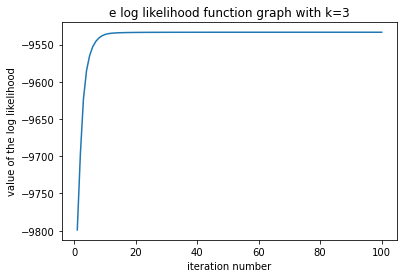

In [200]:
x_range = list(range(1, len(log)+1))
#plt.yscale('log',base=10) 
plt.plot(x_range, log)
plt.title('e log likelihood function graph with k=3')
plt.ylabel('value of the log likelihood')
plt.xlabel('iteration number')
plt.savefig('images/log_likelihood.png')
plt.show()

In [201]:
df_copy = classify_by_r(r=r)

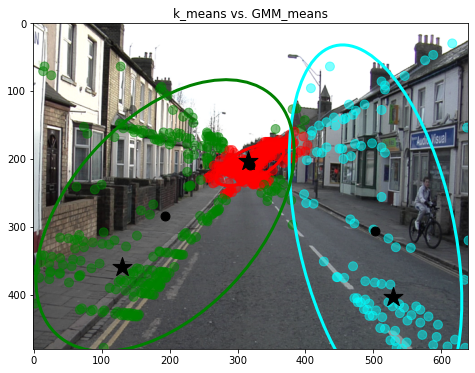

<Figure size 432x288 with 0 Axes>

In [207]:
plot("k_means vs. GMM_means", colors=['cyan', 'green', 'red'], gmm=gmm)

## 3. Hyper-parameter optimization

Plot the mean pseudo-loglikelihood as a polyline plot as a function of K.

In [208]:
def GMM2DXvalK(ks=[], data=df):
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    single_log = []
    logs = []
    
    for k in ks:
        for train, test in kfold.split(data):
            #log_likelihood, r = iter_em(50, 3, data[train], init_mu, full_cov)
            gmm = GaussianMixture(n_components=k, random_state=0)
            gmm.fit(data.iloc[train])
            gmm.predict(data.iloc[test])
            single_log.append(gmm.score(data.iloc[test]))
        logs.append(np.mean(single_log))
    
    return logs

In [209]:
ks=[1, 2, 3, 4]
logs = GMM2DXvalK(ks=ks)

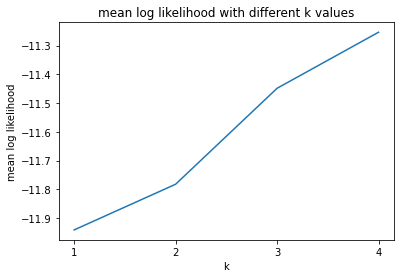

In [210]:
x_range = ks
#plt.yscale('log',base=10) 
plt.plot(x_range, logs)
plt.title('mean log likelihood with different k values')
plt.ylabel('mean log likelihood')
plt.xlabel('k')
plt.xticks(x_range, x_range)
plt.savefig('images/k.png')
plt.show()

In [211]:
def GMM2DXvalCov(cov=[], data=df):
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    single_log = []
    logs = []
    
    for sigma in cov:
        for train, test in kfold.split(data):
            #log_likelihood, r = iter_em(50, 3, data[train], init_mu, full_cov)
            gmm = GaussianMixture(n_components=3, covariance_type=sigma, random_state=0)
            gmm.fit(data.iloc[train])
            gmm.predict(data.iloc[test])
            single_log.append(gmm.score(data.iloc[test]))
        logs.append(np.mean(single_log))
    return logs

In [212]:
cov=['full', 'diag', 'spherical']
logs = GMM2DXvalCov(cov=cov)

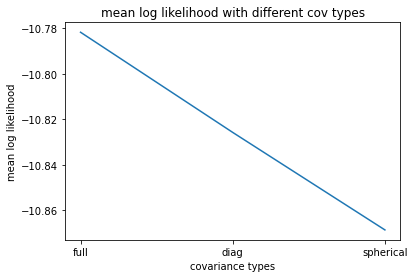

In [213]:
x_range = cov
#plt.yscale('log',base=10) 
plt.plot(x_range, logs)
plt.title('mean log likelihood with different cov types')
plt.ylabel('mean log likelihood')
plt.xlabel('covariance types')
plt.xticks(cov, x_range)
plt.savefig('images/cov_types.png')
plt.show()

In [214]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [215]:
train

,x,y
245,307.0,200.0
175,345.0,189.0
638,100.0,238.0
303,304.0,206.0
216,282.0,196.0
...,...,...
211,342.0,194.0
491,322.0,216.0
156,276.0,185.0
484,304.0,216.0


# Gaussian Kernel Density Estimation

In [216]:
def GKDE2D(X=df, bw=25):
#     train, test = train_test_split(X, test_size=0.2)
    
#     kde_gauss = KernelDensity(kernel='gaussian', bandwidth=bw)
#     kde_gauss.fit(train)
#     log = kde_gauss.score(test)
    
    m1, m2 = df['x'], df['y']
    xmin = m1.min()
    xmax = m1.max()
    ymin = m2.min()
    ymax = m2.max()
    extent=[xmin, xmax, ymin, ymax]
    
    xx, yy = np.mgrid[xmin:xmax:640j, ymin:ymax:480j]

    position = np.vstack([yy.ravel(), xx.ravel()]).T
    data  = np.vstack([m2, m1]).T

    kde_skl = KernelDensity(bandwidth=25)
    kde_skl.fit(data)


    # score_samples() returns the log-likelihood of the samples
    # get pdf
    z = np.exp(kde_skl.score_samples(position))
    Z = np.reshape(z, xx.shape)

    
    return m1, m2, Z, extent

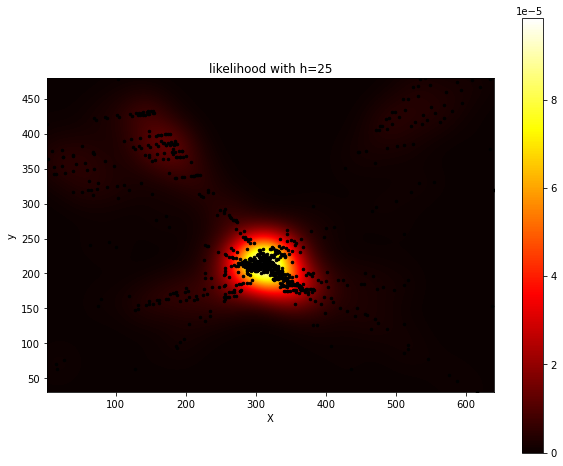

In [217]:
m1, m2, Z, extent = GKDE2D()
fig, ax = plt.subplots(figsize = (10,8))

plt.imshow(np.rot90(Z), cmap=plt.cm.hot,
           extent=extent)

plt.colorbar()
ax.plot(m1, m2, 'k.', markersize=5)
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
plt.title('likelihood with h=25')
plt.xlabel('X')
plt.ylabel('y')
#plt.savefig('likelihood_h25')
plt.show()

Implement a wrapper function GKDEXval that uses 10-fold cross-validation to select
an optimal bandwidth from the set h = [5, 10, …, 50] pixels. 

In [218]:
def GKDEXval(k=10, bw=[], data=df):
    kfold = KFold(n_splits=k, shuffle=True, random_state=1)
    mean_logs= []
    single_logs = []
    for b in bw:
        for train, test in kfold.split(data):
            """Kernel Density Estimation with Scikit-learn"""
            kde_skl = KernelDensity(bandwidth=b)
            kde_skl.fit(data.iloc[train])
            # score_samples() returns the log-likelihood of the samples
            log_pdf = kde_skl.score(data.iloc[test])
            single_logs.append(log_pdf)
        mean_logs.append(np.mean(single_logs))
    return mean_logs

In [219]:
bw = []
for i in range(5, 55, 5):
    bw.append(i)
mean_logs = GKDEXval(k=10, bw=bw)

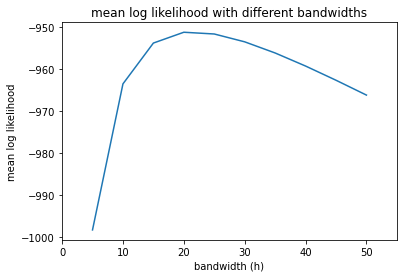

In [220]:
x_range = list(range(5, 55, 5))
#plt.yscale('log',base=10) 
plt.plot(x_range, mean_logs)
plt.xlim(0, 55)
plt.title('mean log likelihood with different bandwidths')
plt.ylabel('mean log likelihood')
plt.xlabel('bandwidth (h)')
plt.savefig('images/bandwidth.png')
plt.show()

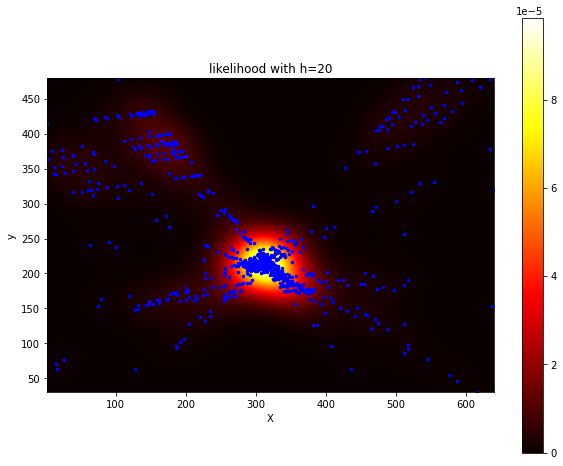

In [221]:
m1, m2, Z, extent = GKDE2D(bw=20)
fig, ax = plt.subplots(figsize = (10,8))

plt.imshow(np.rot90(Z), cmap=plt.cm.hot,
           extent=extent)

plt.colorbar()
ax.plot(m1, m2, 'b.', markersize=5)
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
plt.title('likelihood with h=20')
plt.xlabel('X')
plt.ylabel('y')
plt.savefig('likelihood_h20')
plt.show()

In [222]:
print(z.shape)

(307200,)


In [223]:
coordinates = peak_local_max(Z, min_distance=4)

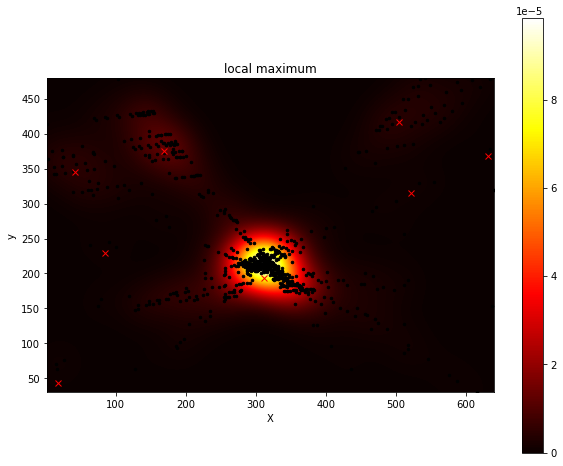

In [224]:
fig, ax = plt.subplots(figsize = (10,8))

plt.imshow(np.rot90(Z), cmap=plt.cm.hot,
           extent=[xmin, xmax, ymin, ymax])

plt.colorbar()
ax.plot(m1, m2, 'k.', markersize=5)
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
ax.plot(coordinates[:, 0], coordinates[:, 1], 'r.', marker='x')
plt.title('local maximum')
plt.xlabel('X')
plt.ylabel('y')
plt.savefig('./images/local_max')
plt.show()

In [225]:
print(len(coordinates))

9
